### Dependencies

In [2]:
### Dependencies
# Base Dependencies
import os
import pickle
import sys

# LinAlg / Stats / Plotting Dependencies
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
#import umap
#import umap.plot
from tqdm import tqdm

# Torch Dependencies
import torch
import torch.multiprocessing
import torchvision
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import default_collate 
from torchvision import transforms
from pl_bolts.models.self_supervised import resnets
from pl_bolts.utils.semi_supervised import Identity
from einops import rearrange, repeat
torch.multiprocessing.set_sharing_strategy('file_system')

# Dependencies from other packages / scripts
sys.path.append('../Attention-Visualization/')
sys.path.append('../Hierarchical-Pretraining/')
from attention_visualization_utils import get_vit256, get_vit4k, tensorbatch2im, getConcatImage
import vision_transformer as vits
import vision_transformer4k as vits4k
from resnet_trunc import resnet50_trunc_baseline

# Fishing Rod Dependencies
sys.path.append('../../Fishing-Rod/')
from wsi_core.wsi_utils import filterPatch

# region_extraction_utils
import importlib
import region_extraction_utils, CustomDataset
importlib.reload(region_extraction_utils)
importlib.reload(CustomDataset)
from region_extraction_utils import *
from CustomDataset import ImageFolder_WithFname, CSVDataset_DigestPath, id_collate

In [41]:
region_datasets = '/media/hdd2/RegionDatasets/CRC-Grading/Processed/'
dataroot = os.path.join(region_datasets, 'CRC_Grading_Extended')
eval_t = eval_transforms(is_imagenet=False)
self = CSVDataset_CRC_Ex(
    dataroot=dataroot,
    csv_path=os.path.join(region_datasets, 'Fold_Info.csv'),
    transforms_eval=eval_t
)

In [40]:
class CSVDataset_CRC_Ex(Dataset):    
    def __init__(self, dataroot, csv_path, transforms_eval, fold_id=1):
        self.dataroot = dataroot
        self.fold_id = fold_id
        assert fold_id in [1,2,3]
        self.csv = pd.read_csv(csv_path)
        self.csv.columns = ['img_fname', 'fold_id']
        self.csv['label'] = self.csv['img_fname'].str.split('_', expand=True)[0].map({'Grade1':0, 'Grade2':1, 'Grade3':2})
        self.csv = self.csv[self.csv['fold_id']==fold_id]
        self.transforms = transforms_eval

    def __getitem__(self, index):
        img_fname = self.csv['img_fname'][index]
        label = self.csv['label'][index]
        img = Image.open(os.path.join(self.dataroot, img_fname))
        return self.transforms(img), torch.Tensor(label), img_fname

    def __len__(self):
        return self.csv.shape[0]

### How Patch Filtering Works

Image Size: (19192, 28621)


100%|█████████████████████████████████████| 8214/8214 [00:04<00:00, 1747.00it/s]


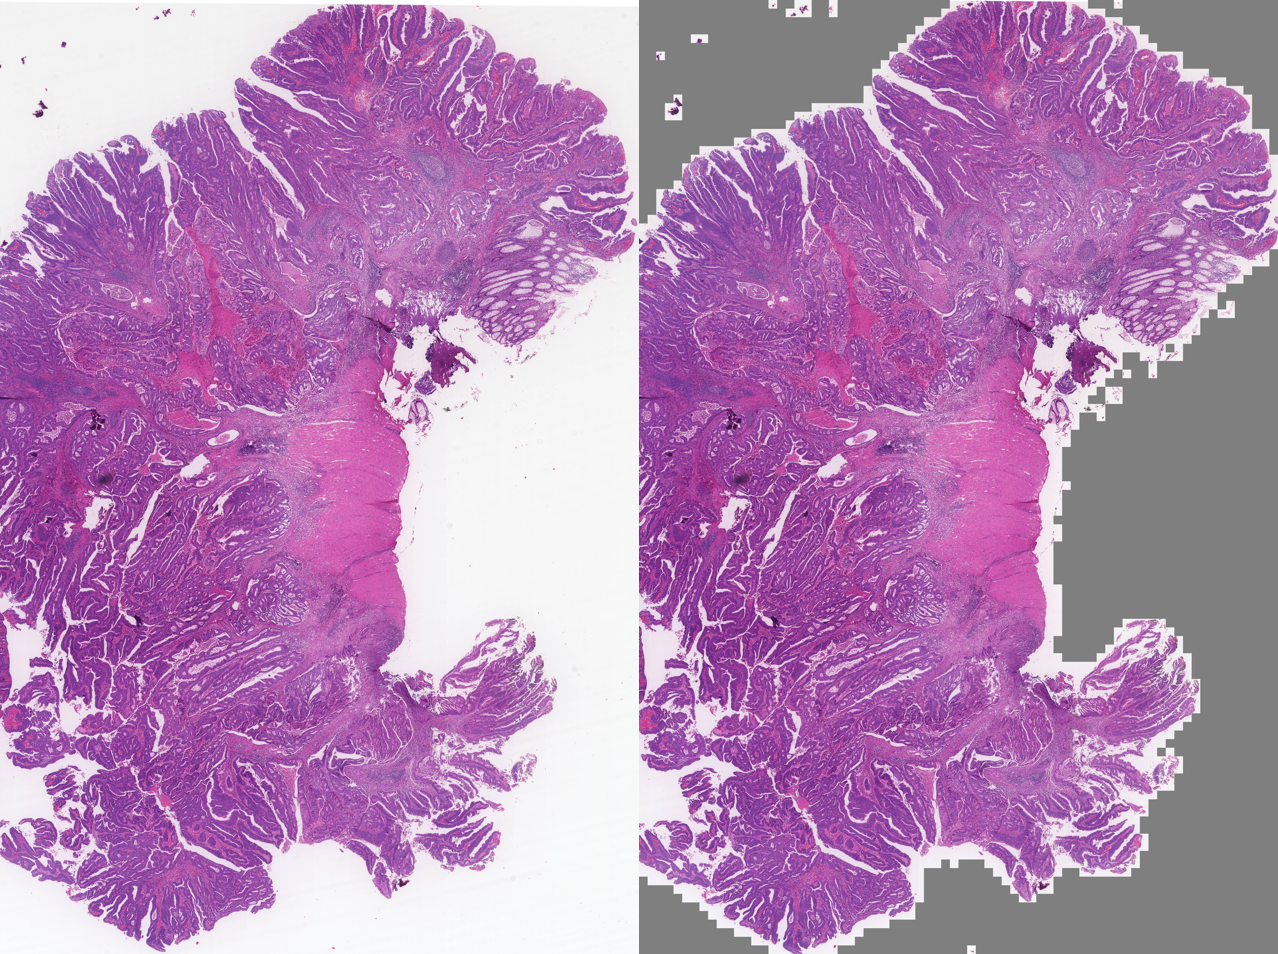

In [43]:
img = Image.open('./example_imgs/DigestPath/D20170502603_2019-05-14 11_39_00-lv1-19545-91-19192-28621.jpg')
print("Image Size:", img.size)
batch_256, w_256, h_256 = prepare_img_tensor(eval_transforms()(img).unsqueeze(dim=0))
batch_256 = batch_256.unfold(2, 256, 256).unfold(3, 256, 256)
batch_256 = rearrange(batch_256, 'b c p1 p2 w h -> (b p1 p2) c w h')

patch_filter_params = patch_filter_params={'isWhitePatch': {'satThresh': 5}, 
                                           'isBlackPatch': {'rgbThresh': 40}}
to_filter = np.array([filterPatch(img, patch_filter_params) for img in tqdm(tensorbatch2im(batch_256))])
contains_tissue = 1-to_filter
batch_256_filter = batch_256
batch_256_filter[np.where(to_filter)] = torch.zeros(3, 256, 256)
img_rp = roll_batch2img(batch_256_filter, w_256, h_256)

getConcatImage([img.resize((img.size[0]//30, img.size[1]//30)),
                img_rp.resize((img.size[0]//30, img.size[1]//30))])

In [2]:
import openslide
wsi = openslide.open_slide('./example_imgs/pandas/39b20d5c2588bafb42c5d6915de11b6b.tiff')

In [8]:
wsi.properties

<_PropertyMap {'openslide.level-count': '3', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '39168', 'openslide.level[0].tile-height': '512', 'openslide.level[0].tile-width': '512', 'openslide.level[0].width': '83968', 'openslide.level[1].downsample': '4', 'openslide.level[1].height': '9792', 'openslide.level[1].tile-height': '512', 'openslide.level[1].tile-width': '512', 'openslide.level[1].width': '20992', 'openslide.level[2].downsample': '16', 'openslide.level[2].height': '2448', 'openslide.level[2].tile-height': '512', 'openslide.level[2].tile-width': '512', 'openslide.level[2].width': '5248', 'openslide.quickhash-1': '4c5346f76b5b008a304cdb7b386242ffa681da047b72ab8630065c1d7f5d2d6a', 'openslide.vendor': 'generic-tiff', 'tiff.ResolutionUnit': 'centimeter', 'tiff.XResolution': '22123', 'tiff.YResolution': '22123'}>

### Example HIPT Forward Pass

In [3]:
region = Image.open('./example_imgs/ICIAR2018/b005.tif')
x = eval_transforms()(region).unsqueeze(dim=0)

pretrained_weights256 = '../Checkpoints/vit256_small_dino.pth'
pretrained_weights4k = '../Checkpoints/vit4k_xs_dino.pth'
device256 = torch.device('cuda:0')
device4k = torch.device('cuda:1')
model = HIPT_4K(pretrained_weights256, pretrained_weights4k, device256, device4k)
model.eval()
asset_dict = model.forward_asset_dict(x)
asset_dict.keys()

Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
# of Patches: 196
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit4k_xs_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


/home/richard/anaconda3/envs/tiatools/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/richard/anaconda3/envs/tiatools/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


dict_keys(['features_cls256', 'features_mean256', 'contains_tissue_256', 'features_cls4k', 'features_mean256_cls4k'])

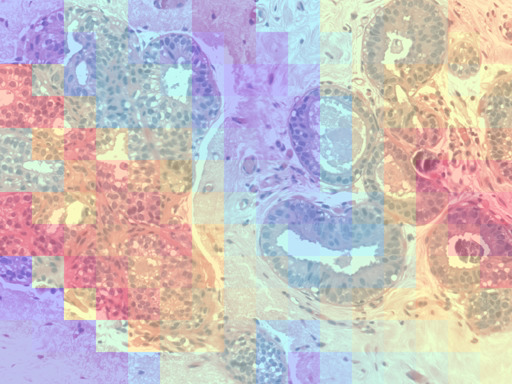

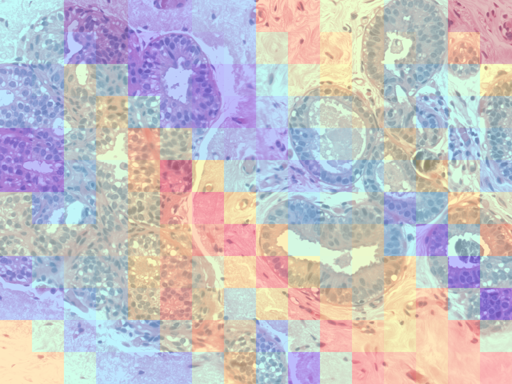

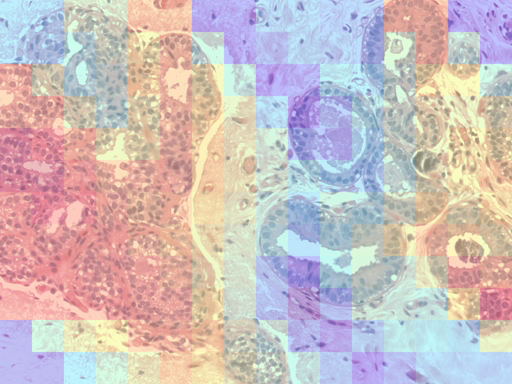

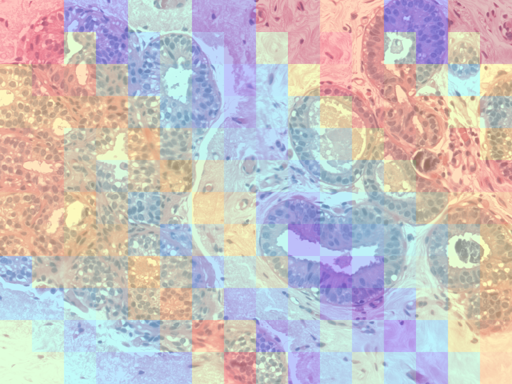

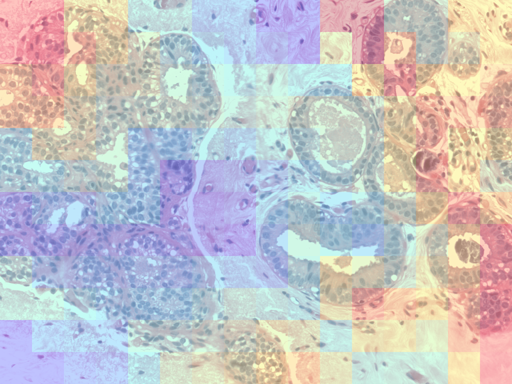

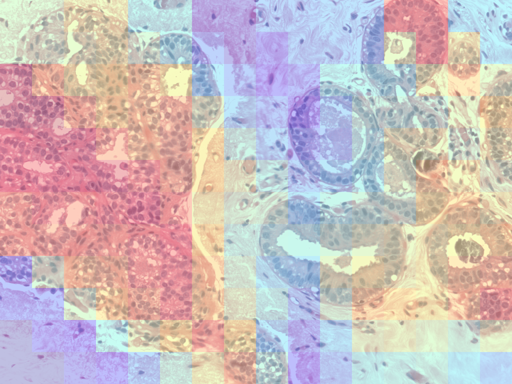

In [4]:
hm4k, hm256, hm4k_256 = model.get_region_heatmaps(x, scale=1)
for img in hm4k:
    display(img.resize((512, 384)))

### Extracting Patch Features

In [5]:
# region_extraction_utils
import importlib
import region_extraction_utils, CustomDataset
importlib.reload(region_extraction_utils)
importlib.reload(CustomDataset)
from region_extraction_utils import *
from CustomDataset import ImageFolder_WithFname, CSVDataset_DigestPath, id_collate

In [6]:
### Extracting Patch Features
region_datasets = '/media/hdd2/RegionDatasets/'
library_path = './embeddings_region_lib/'
os.makedirs(library_path, exist_ok=True)
models = [('resnet50trunc', 'mean256'),
          ('hipt_4k', 'mean256'),
          ('hipt_4k', 'cls4k'),
          ('hipt_4k', 'mean256_cls4k')]

for enc_name, embedding_type in models:
    create_region_embeddings(region_datasets=region_datasets, embeddings_dir=library_path, 
                             enc_name=enc_name, embedding_type=embedding_type, 
                             dataset='iciarbach_raw')
    create_region_embeddings(region_datasets=region_datasets, embeddings_dir=library_path, 
                             enc_name=enc_name, embedding_type=embedding_type, 
                             dataset='iciarbach_sn')
    create_region_embeddings(region_datasets=region_datasets, embeddings_dir=library_path, 
                             enc_name=enc_name, embedding_type=embedding_type, 
                             dataset='digestpath_lesionseg')
    create_region_embeddings(region_datasets=region_datasets, embeddings_dir=library_path, 
                             enc_name=enc_name, embedding_type=embedding_type, 
                             dataset='lymphomaTMA')
    pass

Extracting Features for 'iciarbach_raw' via 'resnet50trunc' with 'mean256'
Extracting Features for 'iciarbach_sn' via 'resnet50trunc' with 'mean256'
Extracting Features for 'digestpath_lesionseg' via 'resnet50trunc' with 'mean256'
Extracting Features for 'lymphomaTMA' via 'resnet50trunc' with 'mean256'


1it [00:00,  1.22it/s]

Img Shape torch.Size([1, 3, 4420, 4420]) Feature Shape (1, 1024)


772it [01:43,  7.48it/s]


Extracting Features for 'iciarbach_raw' via 'hipt_4k' with 'mean256'
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
# of Patches: 196
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit4k_xs_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting Features for 'iciarbach_sn' via 'hipt_4k' with 'mean256'
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit256_small_dino.pth and loaded with msg

0it [00:00, ?it/s]/home/richard/anaconda3/envs/tiatools/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/richard/anaconda3/envs/tiatools/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
1it [00:02,  2.32s/it]

Img Shape torch.Size([1, 3, 4420, 4420]) Feature Shape (1, 384)


772it [06:04,  2.12it/s]


Extracting Features for 'iciarbach_raw' via 'hipt_4k' with 'cls4k'
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
# of Patches: 196
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit4k_xs_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting Features for 'iciarbach_sn' via 'hipt_4k' with 'cls4k'
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit256_small_dino.pth and loaded with msg: _I

1it [00:00,  1.21it/s]

Img Shape torch.Size([1, 3, 4420, 4420]) Feature Shape (1, 192)


772it [01:43,  7.42it/s]


Extracting Features for 'iciarbach_raw' via 'hipt_4k' with 'mean256_cls4k'
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
# of Patches: 196
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit4k_xs_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Extracting Features for 'iciarbach_sn' via 'hipt_4k' with 'mean256_cls4k'
Take key teacher in provided checkpoint dict
Pretrained weights found at ../Checkpoints/vit256_small_dino.pth and loa

1it [00:00,  1.20it/s]

Img Shape torch.Size([1, 3, 4420, 4420]) Feature Shape (1, 576)


772it [01:44,  7.40it/s]
